<a href="https://colab.research.google.com/github/CooperJB710/DS2002-Data-Project-1/blob/main/ETL_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
# Cell 1: Imports & Globals

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


STATE_MAP = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Reverse map so that "AK" -> "Alaska"
ABBR_TO_FULL = {abbrev: name for name, abbrev in STATE_MAP.items()}

CDC_API_JSON_URL = "https://data.cdc.gov/resource/unsk-b7fc.json"
CSV_PATH = "/content/NST-EST2023-POPCHG2020_2023.csv"
YEAR_LIST = [2020, 2021, 2022]

pd.options.display.float_format = '{:,.0f}'.format


In [123]:
def extract_cdc_vaccination_data():
    chunk_size = 1000
    offset = 0
    all_chunks = []

    while True:
        params = {"$limit": chunk_size, "$offset": offset}
        try:
            resp = requests.get(CDC_API_JSON_URL, params=params, timeout=30)
        except Exception as e:
            print(f"Request error: {e}")
            break

        if resp.status_code != 200 or not resp.text.strip():
            print("No more data or bad response.")
            break

        chunk_df = pd.json_normalize(resp.json())
        if chunk_df.empty:
            print("Empty chunk encountered.")
            break

        all_chunks.append(chunk_df)
        offset += chunk_size

    if not all_chunks:
        print("No data retrieved from the API.")
        return pd.DataFrame()

    df_raw = pd.concat(all_chunks, ignore_index=True)
    needed = ["date","location","series_complete_yes"]
    for col in needed:
        if col not in df_raw.columns:
            df_raw[col] = np.nan

    df = df_raw[needed].copy()
    df["date"] = df["date"].astype(str).str[:4]
    df["year"] = pd.to_numeric(df["date"], errors="coerce")
    df.drop(columns="date", inplace=True)
    df = df[df["year"].isin(YEAR_LIST)]
    df["location"] = df["location"].fillna("").str.upper().str.strip()
    df["series_complete_yes"] = pd.to_numeric(df["series_complete_yes"], errors="coerce")
    df.dropna(subset=["year","location","series_complete_yes"], inplace=True)
    df = df[df["location"] != ""]
    df.drop_duplicates(subset=["year","location"], keep="first", inplace=True)
    df.rename(columns={"location":"State"}, inplace=True)
    return df[["year","State","series_complete_yes"]]


In [124]:
def load_census_population_data(csv_path):
    try:
        df_csv = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    if df_csv.empty:
        print("Census CSV contains no data.")
        return pd.DataFrame()

    df_csv.rename(columns={
        "NAME":"State",
        "POPESTIMATE2020":"popestimate2020",
        "POPESTIMATE2021":"popestimate2021",
        "POPESTIMATE2022":"popestimate2022"
    }, inplace=True, errors="ignore")

    for col in ["popestimate2020","popestimate2021","popestimate2022"]:
        if col in df_csv.columns:
            df_csv[col] = pd.to_numeric(df_csv[col], errors="coerce")

    df_csv["State"] = df_csv["State"].fillna("").str.strip()
    df_csv = df_csv[df_csv["State"] != ""]

    keep_cols = ["State","popestimate2020","popestimate2021","popestimate2022"]
    existing = [c for c in keep_cols if c in df_csv.columns]
    df_csv = df_csv[existing]

    if df_csv.empty:
        print("Warning: After cleaning, no rows remain.")
    return df_csv


In [125]:
def transform_data(df_api, df_csv):
    if df_api.empty or df_csv.empty:
        print("One or both DataFrames are empty. Skipping merge.")
        return pd.DataFrame()

    df_api["StateFull"] = df_api["State"].map(ABBR_TO_FULL)
    df_api = df_api.dropna(subset=["StateFull"])

    pivoted = df_api.pivot(index="StateFull", columns="year", values="series_complete_yes").reset_index()

    for y in YEAR_LIST:
        col_old = y
        col_new = f"vaccinated_pop{y}"
        if col_old in pivoted.columns:
            pivoted.rename(columns={col_old:col_new}, inplace=True)
        else:
            pivoted[col_new] = 0

    merged = pd.merge(pivoted, df_csv, left_on="StateFull", right_on="State", how="inner")
    final_cols = [
        "State","popestimate2020","popestimate2021","popestimate2022",
        "vaccinated_pop2020","vaccinated_pop2021","vaccinated_pop2022"
    ]
    df_final = merged[final_cols].copy()

    for col in ["vaccinated_pop2020","vaccinated_pop2021","vaccinated_pop2022"]:
        df_final.loc[:, col] = df_final[col].fillna(0).round().astype(int)

    for col in ["popestimate2020","popestimate2021","popestimate2022"]:
        df_final.loc[:, col] = df_final[col].fillna(0).round().astype(int)

    return df_final


In [126]:
def analyze_data(merged_df):
    for year in [2021, 2022]:
        pop_col = f"popestimate{year}"
        vacc_col = f"vaccinated_pop{year}"
        if pop_col not in merged_df.columns or vacc_col not in merged_df.columns:
            continue
        df_year = merged_df.dropna(subset=[pop_col, vacc_col])
        df_year = df_year[df_year[pop_col] > 0]
        top_10_vacc = df_year.nlargest(10, vacc_col)
        x_vals = range(len(top_10_vacc))
        plt.figure()
        plt.bar(x_vals, top_10_vacc[vacc_col], width=0.4, label="Vaccinated Pop", color='blue')
        plt.bar([x + 0.4 for x in x_vals], top_10_vacc[pop_col], width=0.4, label="Total Pop", color='red')
        plt.xticks([x + 0.2 for x in x_vals], top_10_vacc["State"], rotation=45)
        plt.title(f"Top 10 States by Vaccinated Population ({year})")
        plt.legend()
        plt.tight_layout()
        plt.show()
        top_10_pop = df_year.nlargest(10, pop_col)
        x_vals = range(len(top_10_pop))
        plt.figure()
        plt.bar(x_vals, top_10_pop[pop_col], width=0.4, label="Total Pop", color='red')
        plt.bar([x + 0.4 for x in x_vals], top_10_pop[vacc_col], width=0.4, label="Vaccinated Pop", color='blue')
        plt.xticks([x + 0.2 for x in x_vals], top_10_pop["State"], rotation=45)
        plt.title(f"Top 10 States by Total Population ({year})")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [127]:
import sqlite3
from pathlib import Path

def store_data_in_sqlite(df_merged):
    try:
        db_path = Path("etl_pipeline_database.db")
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS vaccination_data (
                State TEXT,
                popestimate2020 INTEGER,
                popestimate2021 INTEGER,
                popestimate2022 INTEGER,
                vaccinated_pop2020 INTEGER,
                vaccinated_pop2021 INTEGER,
                vaccinated_pop2022 INTEGER
            )
        """)
        cursor.execute("DELETE FROM vaccination_data")
        df_merged.to_sql('vaccination_data', conn, if_exists='append', index=False)
        conn.commit()
        cursor.close()
        conn.close()
        print("Data successfully stored in SQLite.")
    except Exception as e:
        print("SQLite storage failed: {e}")


Extracting CDC data with offset-based paging...
Empty chunk encountered.
Loading local census CSV...
Transform & merge...
Analyze data...


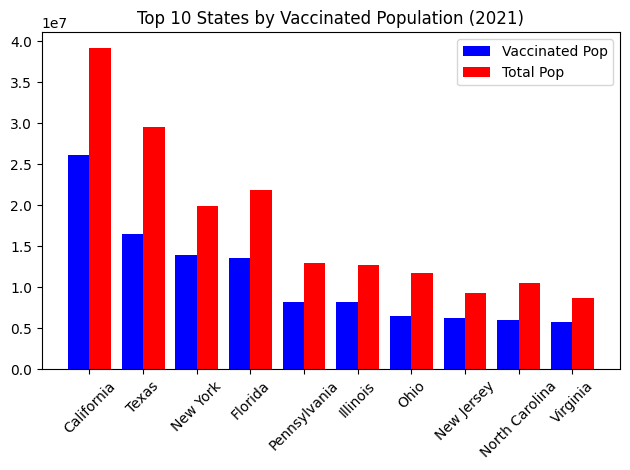

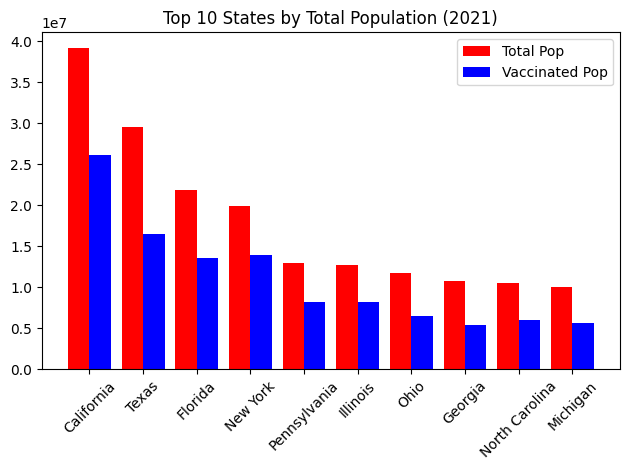

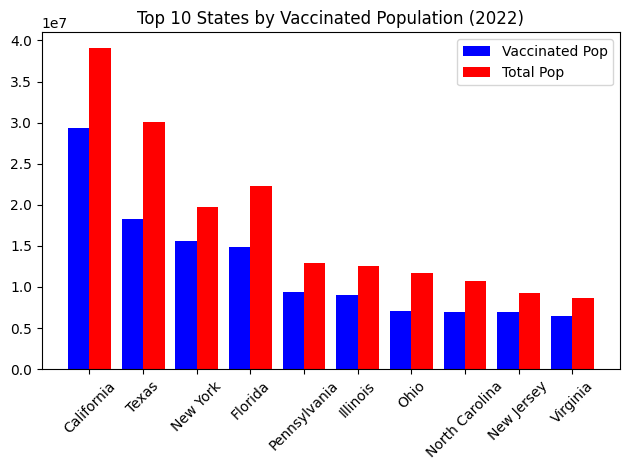

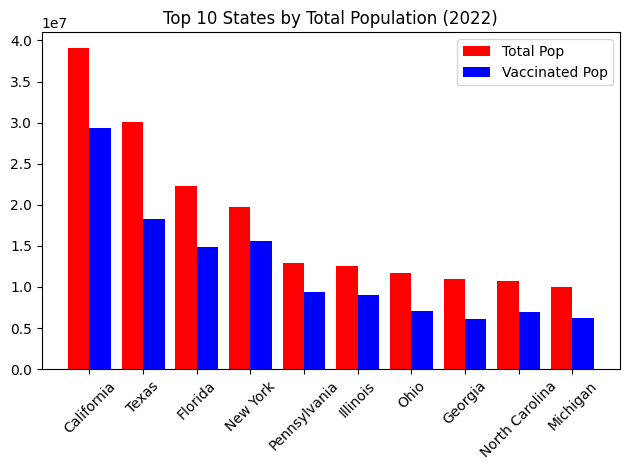

Store in SQLite...
Data successfully stored in SQLite.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ETL complete.


In [128]:
def main():
    print("Extracting CDC data with offset-based paging...")
    df_api = extract_cdc_vaccination_data()

    print("Loading local census CSV...")
    csv_path = "/content/NST-EST2023-POPCHG2020_2023.csv"
    df_csv = load_census_population_data(csv_path)

    print("Transform & merge...")
    df_merged = transform_data(df_api, df_csv)

    print("Analyze data...")
    analyze_data(df_merged)

    print("Store in SQLite...")
    store_data_in_sqlite(df_merged)
    from google.colab import files
    files.download("etl_pipeline_database.db")

    print("ETL complete.")

if __name__ == "__main__":
    main()